## Model - SE Module YOLOv8 (attention)
## type - All In One 
## Dataset - Extended
## Test - VisDrone

# 1. Install Dependencies

In [1]:
# !git clone https://github.com/RuiyangJu/Fracture_Detection_Improved_YOLOv8.git
!git clone https://github.com/mohitsharma-iitj/SEblock_yolov8.git


Cloning into 'SEblock_yolov8'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 189 (delta 27), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (189/189), 3.00 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
%cd SEblock_yolov8

/kaggle/working/SEblock_yolov8


In [3]:
%pip install -r requirements.txt

  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.8/530.8 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00
  C

# 2. Dataset Preparation (Annotation)

as the format of annotation is as - object-class,x_center,y_center,width,height (all normalized as this is input format for YOLO5 prediction)

igiven annotation (in pixel) - bbox_left, bbox_top, bbox_width, bbox_height, score, object_category, truncation, occlusion

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

os.makedirs('/kaggle/working/yolo_dataset/images', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/labels', exist_ok=True)


os.makedirs('/kaggle/working/yolo_dataset/images/train', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/images/val', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/images/test', exist_ok=True)

os.makedirs('/kaggle/working/yolo_dataset/labels/train', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/labels/val', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/labels/test', exist_ok=True)

In [5]:
# Function to get image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height


# Function to convert annotations
def convert_to_yolo_format(filename, annotations, img_width, img_height,output_annotations_path):
    with open(os.path.join(output_annotations_path, filename), 'w') as out_file:
        for annotation in annotations:
            if len(annotation) != 8:
                print(f"Error parsing annotation in {filename}: {annotation}")
                print(f"Ignoring malformed annotation: {annotation}")
                continue
            x_min, y_min, width, height, score, class_id, truncation, occlusion = map(float, annotation)
            if(class_id==0):
                continue
            # Convert to YOLO format
            center_x = x_min + (width / 2.0)
            center_y = y_min + (height / 2.0)
            center_x /= img_width
            center_y /= img_height
            width /= img_width
            height /= img_height
            class_id = class_id -1
            out_file.write(f"{int(class_id)} {center_x} {center_y} {width} {height}\n")

In [6]:
def create_dataset(annotations_path,images_path,output_dataset_path,xx):
    lab_ = 'labels/'+ xx
    img_ = 'images/'+ xx
    output_annotations_path = os.path.join(output_dataset_path, lab_)
    output_images_path = os.path.join(output_dataset_path, img_)


    os.makedirs(output_annotations_path, exist_ok=True)
    os.makedirs(output_images_path, exist_ok=True)

    # Process all annotation files
    for annotation_file in os.listdir(annotations_path):
        image_file = annotation_file.replace('.txt', '.jpg')
        image_path = os.path.join(images_path, image_file)

        if not os.path.exists(image_path):
            continue

        img_width, img_height = get_image_dimensions(image_path)

        with open(os.path.join(annotations_path, annotation_file), 'r') as file:
            lines = file.readlines()
            annotations = [line.strip().split(',') for line in lines]
            convert_to_yolo_format(annotation_file, annotations, img_width, img_height,output_annotations_path)

            # Copy the image to the new dataset location
            output_image_path = os.path.join(output_images_path, image_file)
            if not os.path.exists(output_image_path):
                Image.open(image_path).save(output_image_path)

## for train + val (from extended)

In [7]:
# Paths to the dataset
annotations_path = '/kaggle/input/extended-dataset/Expanded_dataset/annotations'
images_path = '/kaggle/input/extended-dataset/Expanded_dataset/images'
output_dataset_path = '/kaggle/working/yolo_annotations'

create_dataset(annotations_path,images_path,output_dataset_path,'temp')



In [8]:
output_annotations_path = '/kaggle/working/yolo_annotations/labels/temp'

# Split the data
image_files = os.listdir(images_path)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Move files
for file in train_files:
    shutil.copy(os.path.join(images_path, file), '/kaggle/working/yolo_dataset/images/train/')
    shutil.copy(os.path.join(output_annotations_path, file.replace('.jpg', '.txt')), '/kaggle/working/yolo_dataset/labels/train/')

for file in val_files:
    shutil.copy(os.path.join(images_path, file), '/kaggle/working/yolo_dataset/images/val/')
    shutil.copy(os.path.join(output_annotations_path, file.replace('.jpg', '.txt')), '/kaggle/working/yolo_dataset/labels/val/')


## for test dataset (from VisDrone)

In [9]:
# Paths to the dataset
annotations_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/annotations'
images_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images'
output_dataset_path = '/kaggle/working/yolo_dataset'

create_dataset(annotations_path,images_path,output_dataset_path,'test')

# 3. Create a Dataset Configuration File

In [10]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/val
test: /kaggle/working/yolo_dataset/images/test

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
    file.write(data_config)



# Training Yolov8s

In [11]:
import wandb 
from ultralytics import YOLO

In [12]:
def train_on_extended(model,epoch_):
    !export WANDB_MODE=disabled
    wandb.init(mode="disabled")
    # Load a model
    model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt")  # load a partially trained model (checkpoint of last trained)

    # Train the model  #  X(from model,previous) + Y (=epoch_) = given segment epoch
    results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=epoch_, imgsz=640, batch=8)
    

# epoch = 10

#### Training on Extended  epoch=10 

In [13]:
!export WANDB_MODE=disabled
wandb.init(mode="disabled")


# Load a YOLOv8 model
model = YOLO('/kaggle/working/SEblock_yolov8/ultralytics/cfg/models/v8/yolov8_SEModule.yaml').load('/kaggle/working/SEblock_yolov8/yolov8n.pt')  # You can also use yolov8m.pt, yolov8l.pt, etc.

# Train the model
results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=10, imgsz=640, batch=8)

WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295

In [14]:
# !gdown https://github.com/RuiyangJu/Fracture_Detection_Improved_YOLOv8/releases/download/YOLOv8_ResCBAM/YOLOv8_ResCBAM.pt
# !python start_train.py --model ./ultralytics/cfg/models/v8/yolov8_ResBlock_CBAM.yaml --data_dir ./GRAZPEDWRI-DX/data/meta.yaml


#### Val on extended  epoch=10 

In [15]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:12<00:00,  2.66it/s]
                   all        261       9058      0.658      0.292      0.272      0.175
            pedestrian        261       2457      0.425      0.348      0.312      0.138
                people        261        810      0.583     0.0811      0.134     0.0561
               bicycle        261        12

#### test on visdrone  epoch=10

In [16]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
val: Scanning /kaggle/working/yolo_dataset/labels/test... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:01<00:00, 1053.36it/s]
val: New cache created: /kaggle/working/yolo_dataset/labels/test.cache
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:33<00:00,  6.01it/s]
                   all       1610      75367    0.00971     0.0516    0.00907    0.00305
            pedestrian       1610      21006     0.0087     0.0205    0.00457    0.00114
                people       1610       6376     0.0048     0.0348    0.00326   0.000896
               bicycle       1610       1302   0.00

# Epoch=25

In [17]:
train_on_extended(model,15)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=15, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save_hybrid=False, conf=N

In [18]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.91it/s]
                   all        261       9058      0.658      0.292      0.272      0.175
            pedestrian        261       2457      0.425      0.348      0.312      0.138
                people        261        810      0.583     0.0811      0.134     0.0561
               bicycle        261        124          1          0     0.0241     0.0099
                   car        261       339

#### test on visdrone  epoch=25

In [19]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
val: Scanning /kaggle/working/yolo_dataset/labels/test.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:54<00:00,  3.69it/s]
                   all       1610      75367    0.00971     0.0516    0.00907    0.00305
            pedestrian       1610      21006     0.0087     0.0205    0.00457    0.00114
                people       1610       6376     0.0048     0.0348    0.00326   0.000896
               bicycle       1610       1302   0.000435    0.00538   0.000226   4.77e-05
                   car       1610    

# Epoch = 50

In [20]:
train_on_extended(model,25)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=25, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save_hybrid=False, conf=N

In [21]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.83it/s]
                   all        261       9058      0.658      0.292      0.272      0.175
            pedestrian        261       2457      0.425      0.348      0.312      0.138
                people        261        810      0.583     0.0811      0.134     0.0561
               bicycle        261        124          1          0     0.0241     0.0099
                   car        261       339

#### test on visdrone  epoch=50

In [22]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
val: Scanning /kaggle/working/yolo_dataset/labels/test.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [01:36<00:00,  2.10it/s]
                   all       1610      75367    0.00971     0.0516    0.00907    0.00305
            pedestrian       1610      21006     0.0087     0.0205    0.00457    0.00114
                people       1610       6376     0.0048     0.0348    0.00326   0.000896
               bicycle       1610       1302   0.000435    0.00538   0.000226   4.77e-05
                   car       1610    

# Epoch = 100

In [23]:
train_on_extended(model,50)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=50, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save_hybrid=False, conf=N

In [24]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:53<00:00,  1.63s/it]
                   all        261       9058      0.658      0.292      0.272      0.175
            pedestrian        261       2457      0.425      0.348      0.312      0.138
                people        261        810      0.583     0.0811      0.134     0.0561
               bicycle        261        124          1          0     0.0241     0.0099
                   car        261       339

#### test on visdrone  epoch=100

In [25]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
val: Scanning /kaggle/working/yolo_dataset/labels/test.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:56<00:00,  3.56it/s]
                   all       1610      75367    0.00971     0.0516    0.00907    0.00305
            pedestrian       1610      21006     0.0087     0.0205    0.00457    0.00114
                people       1610       6376     0.0048     0.0348    0.00326   0.000896
               bicycle       1610       1302   0.000435    0.00538   0.000226   4.77e-05
                   car       1610    

# 6.a. Make Predictions on Extended from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1.jpg: 448x640 18 pedestrians, 7 peoples, 6 cars, 2 vans, 1 bus, 1 motor, 101.3ms
Speed: 2.6ms preprocess, 101.3ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


Predicted Annotations:
Class: 3, Confidence: 0.9353863000869751, BBox: (575, 9, 598, 32)
Class: 8, Confidence: 0.935028076171875, BBox: (517, 222, 579, 343)
Class: 3, Confidence: 0.9326213002204895, BBox: (413, 437, 487, 507)
Class: 3, Confidence: 0.9305246472358704, BBox: (665, 595, 768, 685)
Class: 3, Confidence: 0.9282146692276001, BBox: (593, 625, 678, 700)
Class: 3, Confidence: 0.9138007760047913, BBox: (342, 284, 388, 340)
Class: 0, Confidence: 0.9098368287086487, BBox: (1060, 598, 1082, 621)
Class: 4, Confidence: 0.888241708278656, BBox: (406, 77, 438, 108)
Class: 4, Confidence: 0.8650920391082764, BBox: (498, 9, 522, 34)
Class: 0, Confidence: 0.8638945817947388, BBox: (195, 486, 207, 500)
Class: 3, Confidence: 0.8582672476768494, BBox: (466, 9, 493, 32)
Class: 0, Confidence: 0.8576705455780029, BBox: (876, 552, 892, 579)
Class: 0, Confidence: 0.837473452091217, BBox: (857, 198, 868, 215)
Class: 0, Confidence: 0.8360270857810974, BBox: (225, 413, 234, 429)
Class: 0, Confidence: 

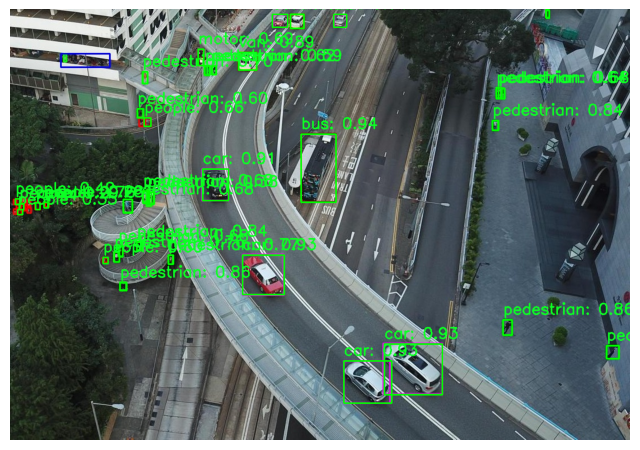


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1011.jpg: 352x640 22 pedestrians, 3 cars, 1 bus, 83.8ms
Speed: 2.8ms preprocess, 83.8ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 8, Confidence: 0.9411661028862, BBox: (219, 65, 356, 359)
Class: 3, Confidence: 0.9247005581855774, BBox: (139, 412, 206, 528)
Class: 3, Confidence: 0.9221208691596985, BBox: (214, 77, 275, 180)
Class: 3, Confidence: 0.9193585515022278, BBox: (657, 327, 711, 441)
Class: 0, Confidence: 0.8861964344978333, BBox: (1168, 14, 1187, 41)
Class: 0, Confidence: 0.8383245468139648, BBox: (433, 246, 453, 263)
Class: 0, Confidence: 0.8327414989471436, BBox: (1065, 36, 1087, 52)
Class: 0, Confidence: 0.8282723426818848, BBox: (1237, 684, 1262, 699)
Class: 0, Confidence: 0.8277140855789185, BBox: (1214, 457, 1232, 469)
Class: 0, Confidence: 0.8264687061309814, BBox: (439, 393, 453, 411)
Class: 0, Confidence: 0.8050523996353149, BBox: (42, 242, 66, 263)
Class: 0, Confidence: 0.7968207001686096, BBox: (1131, 15, 1151, 40)
Class: 0, Confidence: 0.7962701916694641, BBox: (1150, 4, 1169, 33)
Class: 0, Confidence: 0.7853119373321533, BBox: (25, 329, 44, 347)
Class: 0, Confide

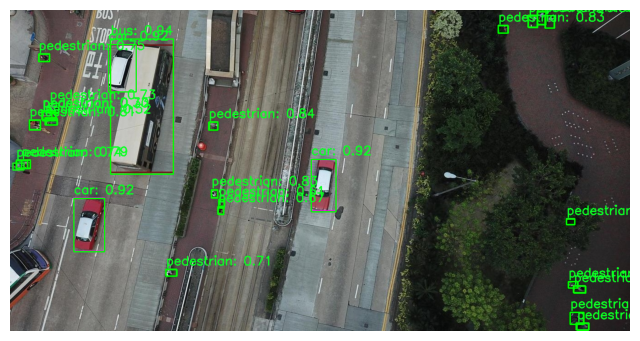


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/932.jpg: 352x640 4 cars, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 3, Confidence: 0.9113149046897888, BBox: (498, 520, 533, 591)
Class: 3, Confidence: 0.891032338142395, BBox: (265, 127, 318, 161)
Class: 3, Confidence: 0.88246089220047, BBox: (598, 58, 620, 102)
Class: 3, Confidence: 0.8644605278968811, BBox: (556, 131, 583, 174)


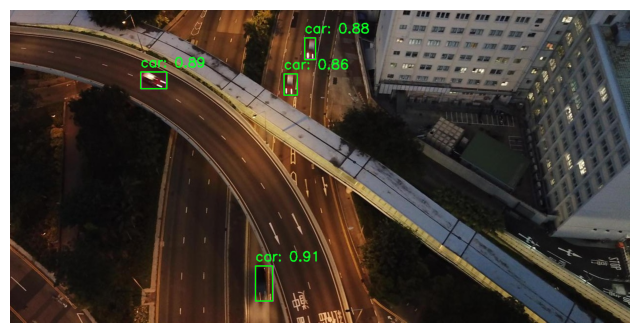


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/846.jpg: 352x640 11 pedestrians, 1 people, 8 bicycles, 24 cars, 1 van, 1 bus, 1 motor, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 3, Confidence: 0.9478784799575806, BBox: (618, 511, 794, 651)
Class: 4, Confidence: 0.9303067922592163, BBox: (177, 295, 249, 347)
Class: 3, Confidence: 0.9203624129295349, BBox: (556, 417, 687, 509)
Class: 3, Confidence: 0.9175690412521362, BBox: (845, 267, 897, 300)
Class: 3, Confidence: 0.9162770509719849, BBox: (689, 268, 734, 301)
Class: 3, Confidence: 0.9107099175453186, BBox: (125, 282, 200, 323)
Class: 3, Confidence: 0.9082642793655396, BBox: (520, 311, 568, 366)
Class: 3, Confidence: 0.8916904330253601, BBox: (624, 231, 647, 255)
Class: 3, Confidence: 0.8831568360328674, BBox: (499, 236, 534, 270)
Class: 3, Confidence: 0.8814119100570679, BBox: (983, 248, 1025, 277)
Class: 3, Confidence: 0.8791540861129761, BBox: (646, 323, 693, 368)
Class: 3, Confidence: 0.8674797415733337, BBox: (955, 205, 1007, 224)
Class: 2, Confidence: 0.8597639203071594, BBox: (1146, 312, 1173, 333)
Class: 2, Confidence: 0.8568466901779175, BBox: (1259, 322, 1288, 351)
Class

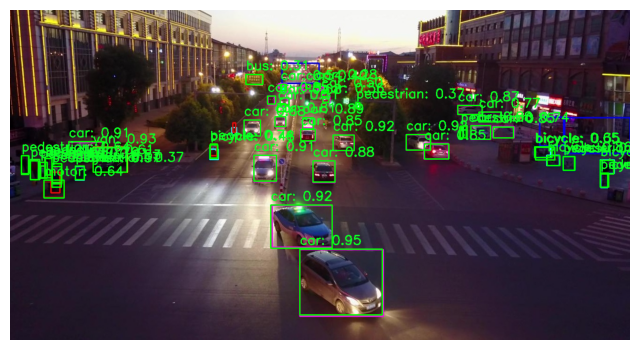


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/493.jpg: 320x640 7 cars, 1 van, 1 bus, 81.9ms
Speed: 3.2ms preprocess, 81.9ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


Predicted Annotations:
Class: 4, Confidence: 0.919195830821991, BBox: (812, 515, 858, 537)
Class: 3, Confidence: 0.9038588404655457, BBox: (473, 361, 498, 403)
Class: 3, Confidence: 0.8936254978179932, BBox: (613, 265, 648, 309)
Class: 3, Confidence: 0.8735066056251526, BBox: (515, 241, 536, 289)
Class: 3, Confidence: 0.8726622462272644, BBox: (428, 5, 449, 58)
Class: 3, Confidence: 0.8710076808929443, BBox: (439, 126, 459, 176)
Class: 8, Confidence: 0.8459764122962952, BBox: (990, 520, 1110, 554)
Class: 3, Confidence: 0.8388780951499939, BBox: (1160, 396, 1212, 416)
Class: 3, Confidence: 0.8231219053268433, BBox: (375, 215, 393, 258)


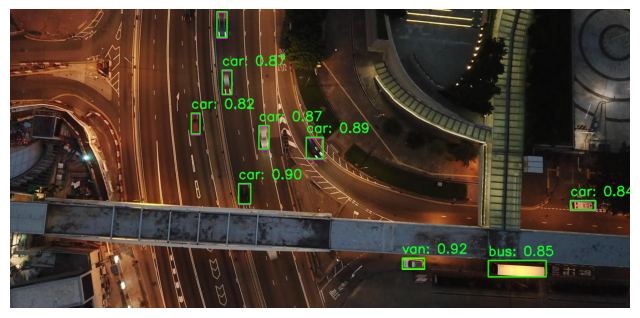

In [26]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO


# Load the trained YOLOv8 model
model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model
# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = [1,1011,932,846,493]
for img_locat in listimg:
    # Define the test image path
    # test_image_path = '/kaggle/input/custom-dataset/images/1001.jpg'
    test_image_path = '/kaggle/input/extended-dataset/Expanded_dataset/images/'+ str(img_locat) + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 6.b. Make Predictions on visdrone from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000006_00159_d_0000001.jpg: 384x640 (no detections), 82.0ms
Speed: 3.5ms preprocess, 82.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Predicted Annotations:


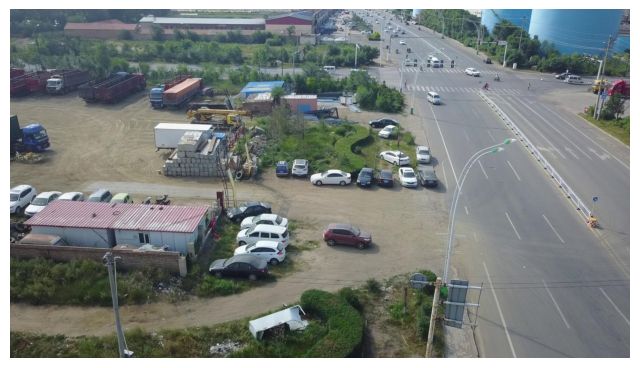


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000054_00786_d_0000001.jpg: 384x640 (no detections), 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Predicted Annotations:


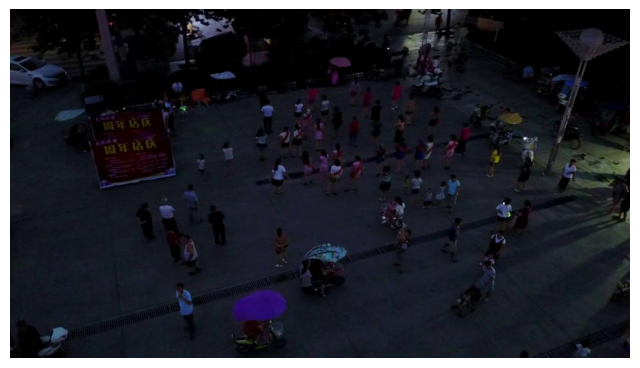

In [27]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model

# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = ['0000006_00159_d_0000001','0000054_00786_d_0000001']
for img_locat in listimg:
    # Define the test image path
    # test_image_path = '/kaggle/input/custom-dataset/images/1001.jpg'
    test_image_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/'+ img_locat + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [28]:
# shutil.rmtree('/kaggle/working/yolo_dataset/val')

# Extra

In [29]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/test

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
    file.write(data_config)

In [30]:
# Load the best model
model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model
# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluate the model on the new dataset
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_SEModule summary (fused): 188 layers, 3009525 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:39<00:00,  2.56it/s]
                   all       1610      75367    0.00901     0.0228    0.00614    0.00209
            pedestrian       1610      21006    0.00347    0.00267    0.00175    0.00042
                people       1610       6376    0.00282     0.0069    0.00143   0.000347
               bicycle       1610    